## GAN anomaly 實作 - anoGAN

程式內容包括:
* 建立anoGAN模型架構
* 訓練anoGAN模型
* Anomaly score計算

使用MNIST資料集 (More info: http://yann.lecun.com/exdb/mnist/)
* train-images-idx3-ubyte.gz:  training set images (9912422 bytes)
* train-labels-idx1-ubyte.gz:  training set labels (28881 bytes)
* t10k-images-idx3-ubyte.gz:   test set images (1648877 bytes)
* t10k-labels-idx1-ubyte.gz:   test set labels (4542 bytes)

### 模型架構說明

![anoGAN](pic_anoGAN/anoGAN.png)

<b> 1.train DCGAN with normal image </b>
* Radford, A., Metz, L., Chintala, S.: Unsupervised representation learning with deep convolutional generative adversarial networks. arXiv:1511.06434 (2015)
![DCGAN](pic_anoGAN/DCGAN.png)

*註: 本範例預訓練的 DCGAN input image x shape:(28x28x1), z: input_dim=100

<b> 2.Mapping new Images to the Latent Space </b>

<b> 2.1 loss </b>
- residual loss : G(z):generator output 與 input data x 的差距 
![residual_loss](pic_anoGAN/residual.png)
- discrimination loss : input x 與 G(z)各自經過discriminator產出output x 及 output G(z)的差異
![discrimination_loss](pic_anoGAN/discrimination.png)
    f(·) : output of an intermediate layer  of the discriminator 
- overall loss : residual loss 跟 discrimination loss 透過 Lambda 加權 (Lambda=0.1)
![overall_loss](pic_anoGAN/overall.png)

<b> 3.anomaly score </b>
* 使用 image x 與 generator G(z)的 residual loss 來做為anomaly score
![residual_img](pic_anoGAN/residual_img.png)


![anoGAN2](pic_anoGAN/anoGAN2.png)

參考文獻: anoGAN paper: https://arxiv.org/abs/1703.05921

In [1]:
import warnings
warnings.filterwarnings("ignore")

### 建構 anoGAN

In [2]:
from keras.models import Sequential, Model
from keras.layers import Input, Reshape, Dense, Dropout, UpSampling2D, Conv2D, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from keras import backend as K
from keras import initializers
import tensorflow as tf
import numpy as np
from tqdm import tqdm

In [3]:
#Generator G(z), z: input_dim=100, 為配合pre-train weight, 請勿更動模型架構
def generator_model():
    generator = Sequential()
    generator.add(Dense(128*7*7, input_dim=100, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    generator.add(LeakyReLU(0.2))
    generator.add(Reshape((7, 7, 128)))
    generator.add(UpSampling2D(size=(2, 2)))
    generator.add(Conv2D(64, kernel_size=(5, 5), padding='same'))
    generator.add(LeakyReLU(0.2))
    generator.add(UpSampling2D(size=(2, 2)))
    generator.add(Conv2D(1, kernel_size=(5, 5), padding='same', activation='tanh'))
    generator.compile(loss='binary_crossentropy', optimizer='adam')
    return generator

In [4]:
#Discriminator D(image x): image x shape (28,28,1), 為配合pre-train weight, 請勿更動模型架構
def discriminator_model():
    discriminator = Sequential()
    discriminator.add(Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same', input_shape=(28,28, 1), kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
    discriminator.add(Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same'))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
    discriminator.add(Flatten())
    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer='adam')
    return discriminator

In [5]:
#GAN: generator + discriminator
def generator_containing_discriminator(g, d):
    d.trainable = False
    ganInput = Input(shape=(100,))
    x = g(ganInput)
    ganOutput = d(x)
    gan = Model(inputs=ganInput, outputs=ganOutput)
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan

In [6]:
# generator及預訓練 weights (DCGAN)
def generate(BATCH_SIZE, G_WEIGHTS='pic_anoGAN/weights/generator'):
    g = generator_model()
    g.load_weights(G_WEIGHTS) #使用的參數權重
    noise = np.random.uniform(0, 1, (BATCH_SIZE, 100))
    generated_images = g.predict(noise)
    return generated_images

In [7]:
#特徵抽取: 使用 discriminator及預訓練 weights (DCGAN)
def feature_extractor(D_WEIGHTS='pic_anoGAN/weights/discriminator'):
    d = discriminator_model()
    d.load_weights(D_WEIGHTS) #使用的參數權重
    intermidiate_model = Model(inputs=d.layers[0].input, outputs=d.layers[-5].output) #d.layers[-5]:'conv2d_1'
    intermidiate_model.compile(loss='binary_crossentropy', optimizer='adam')
    return intermidiate_model

In [8]:
#計算 residual loss
def sum_of_residual(y_true, y_pred):
    return tf.reduce_sum(abs(y_true - y_pred))

In [9]:
#異常偵測模型: Generator + feature_extractor(Lambda=0.1)
def anomaly_detector(Lambda=0.1, G_WEIGHTS='pic_anoGAN/weights/generator'):
    g = generator_model()
    g.load_weights(G_WEIGHTS) #使用的參數權重
    g.trainable = False
    intermidiate_model = feature_extractor()
    intermidiate_model.trainable = False
    
    aInput = Input(shape=(100,))
    gInput = Dense((100))(aInput)
    G_out = g(gInput)
    D_out= intermidiate_model(G_out)    
    model = Model(inputs=aInput, outputs=[G_out, D_out])
    model.compile(loss=sum_of_residual, loss_weights= [1.0-Lambda, Lambda], optimizer='adam')
    return model

In [10]:
#計算 anomaly score (使用anomaly_detector) discriminator及預訓練 weights 來計算image residual score) 
def compute_anomaly_score(model, x, D_WEIGHTS='pic_anoGAN/weights/discriminator'):
    z = np.random.uniform(0, 1, size=(1, 100))
    intermidiate_model = feature_extractor(D_WEIGHTS) # anomaly_detector
    d_x = intermidiate_model.predict(x)
    #給予 z:random noise, x:input image, d_x
    loss = model.fit(z, [x, d_x], epochs=500, verbose=0)
    similar_data, _ = model.predict(z)
    return loss.history['loss'][-1], similar_data

### anoGAN模型訓練流程

In [11]:
import numpy as np
from tqdm import tqdm

NEW_G_WEIGHTS='assets/generator'
NEW_D_WEIGHTS='assets/discriminator'

#模型訓練流程
def anogan_train(X_train, BATCH_SIZE, EPOCHS):
    #### discriminator ####
    d = discriminator_model()
    #### generator ####
    g = generator_model()

    d_on_g = generator_containing_discriminator(g, d)
    d.trainable = True
    
    for epoch in tqdm(range(EPOCHS)):
        for index in range(int(X_train.shape[0]/BATCH_SIZE)):
            noise = np.random.uniform(0, 1, size=(BATCH_SIZE, 100))
            
            image_batch = X_train[index*BATCH_SIZE:(index+1)*BATCH_SIZE]
            generated_images = g.predict(noise, verbose=0)
            X = np.concatenate((image_batch, generated_images))
            y = np.array([1] * BATCH_SIZE + [0] * BATCH_SIZE)
            d_loss = d.train_on_batch(X, y)
            noise = np.random.uniform(0, 1, (BATCH_SIZE, 100))
            
            d.trainable = False
            g_loss = d_on_g.train_on_batch(noise, np.array([1] * BATCH_SIZE))
            d.trainable = True
            
        g.save_weights(NEW_G_WEIGHTS, True) #另存新訓練好的參數權重
        d.save_weights(NEW_D_WEIGHTS, True) #另存新訓練好的參數權重
        
    print('###### training result ######')
    print('d_loss:{} , g_loss(d_on_g):{}'.format(d_loss, g_loss))
    print('save weights, NEW_G_WEIGHTS => ', NEW_G_WEIGHTS)
    print('save weights, NEW_D_WEIGHTS => ', NEW_D_WEIGHTS)
    return d, g

### 模型訓練

In [12]:
from tensorflow.keras.datasets import mnist
#如果可以連外網,它會自己去下載
#(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Get the working directory path
import os
current_dir = os.getcwd()

# Import mnist data stored in the following path: current directory -> /datasets/MNIST/mnist.npz
(X_train, y_train), (X_test, y_test) = mnist.load_data(path=current_dir+'/datasets/MNIST/mnist.npz')

In [13]:
import numpy as np
import matplotlib.pyplot as plt

EPOCHS = 5
BATCH_SIZE = 32

#簡單做一些前處理
X_train = X_train.astype(np.float32)/255.
X_train = X_train[0:100].reshape(100, 28, 28, 1) #total:60000筆資料

Model_d, Model_g = anogan_train(X_train, BATCH_SIZE, EPOCHS)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.51s/it]

###### training result ######
d_loss:0.5606515407562256 , g_loss(d_on_g):1.6291261911392212
save weights, NEW_G_WEIGHTS =>  assets/generator
save weights, NEW_D_WEIGHTS =>  assets/discriminator


In [14]:
print("#### discriminator ######")
Model_d.summary()

#### discriminator ######
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (

In [15]:
print("#### generator ######")
Model_g.summary()

#### generator ######
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        204864    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (No

In [16]:
#使用於feature_extractor 的input & output, 做為特徵抽取使用
Model_d.layers[0].name, Model_d.layers[-5].name

('conv2d', 'conv2d_1')

In [17]:
feature_extractor().summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4_input (InputLayer)  [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 128)         204928    
Total params: 206,592
Trainable params: 206,592
Non-trainable params: 0
_________________________________________________________________


In [18]:
anomaly_detector().summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
sequential_3 (Sequential)    (None, 28, 28, 1)         839937    
_________________________________________________________________
model_2 (Functional)         (None, 7, 7, 128)         206592    
Total params: 1,056,629
Trainable params: 10,100
Non-trainable params: 1,046,529
_________________________________________________________________


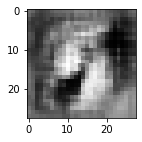

In [19]:
## generate random image 
generated_img = generate(5)
plt.figure(figsize=(2, 2))
plt.imshow(generated_img[0].reshape(28, 28),cmap=plt.cm.gray)
plt.show()

#### 計算 anomaly score (使用test set的image)

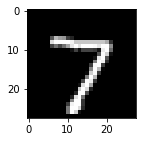

anomaly score : 145.29730224609375


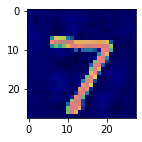

In [20]:
## compute anomaly score - sample from test set

X_test = X_test.astype(np.float32)/255.
X_test = X_test.reshape(-1, 28, 28, 1)
test_img = X_test[0]

#model = anomaly_detector(Lambda=0.1, G_WEIGHTS=NEW_G_WEIGHTS)
model = anomaly_detector(Lambda=0.1)
ano_score, similar_img = compute_anomaly_score(model, test_img.reshape(1, 28, 28, 1), D_WEIGHTS=NEW_D_WEIGHTS)

plt.figure(figsize=(2, 2))
plt.imshow(test_img.reshape(28,28), cmap=plt.cm.gray)
plt.show()
print("anomaly score : " + str(ano_score))
plt.figure(figsize=(2, 2))
plt.imshow(test_img.reshape(28,28), cmap=plt.cm.gray)
residual  = test_img.reshape(28,28) - similar_img.reshape(28, 28)
plt.imshow(residual, cmap='jet', alpha=.5)
plt.show()

#### 計算 anomaly score (使用 test image)

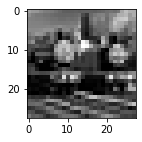

anomaly score : 271.0224304199219


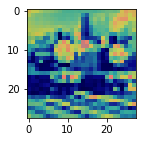

In [21]:
## compute anomaly score - sample from strange image

test_img = plt.imread('pic_anoGAN/test_img.png')
test_img = test_img[:,:,0]

#model = anomaly_detector(Lambda=0.1, G_WEIGHTS=NEW_G_WEIGHTS)
model = anomaly_detector(Lambda=0.1)
ano_score, similar_img = compute_anomaly_score(model, test_img.reshape(1, 28, 28, 1), D_WEIGHTS=NEW_D_WEIGHTS)

plt.figure(figsize=(2, 2))
plt.imshow(test_img.reshape(28,28), cmap=plt.cm.gray)
plt.show()
print("anomaly score : " + str(ano_score))
plt.figure(figsize=(2, 2))
plt.imshow(test_img.reshape(28,28), cmap=plt.cm.gray)
residual  = test_img.reshape(28,28) - similar_img.reshape(28, 28)
plt.imshow(residual, cmap='jet', alpha=.5)
plt.show()

In [22]:
test_img = plt.imread('pic_anoGAN/image_cat.png')
type(test_img), test_img.shape

(numpy.ndarray, (227, 289, 3))

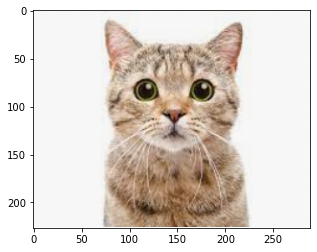

In [23]:
plt.imshow(test_img)

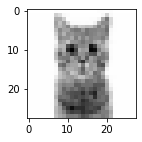

anomaly score : 603.763671875


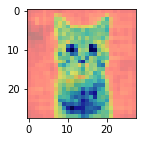

In [24]:
import cv2
image_cat = cv2.imread('pic_anoGAN/image_cat.png')
image_cat = cv2.resize(image_cat, (28, 28), interpolation=cv2.INTER_AREA)
test_img = image_cat[:,:,0].astype(np.float32)/255.

#model = anomaly_detector(Lambda=0.1, G_WEIGHTS=NEW_G_WEIGHTS)
model = anomaly_detector(Lambda=0.1)
ano_score, similar_img = compute_anomaly_score(model, test_img.reshape(1, 28, 28, 1), D_WEIGHTS=NEW_D_WEIGHTS)

plt.figure(figsize=(2, 2))
plt.imshow(test_img.reshape(28,28), cmap=plt.cm.gray)
plt.show()
print("anomaly score : " + str(ano_score))
plt.figure(figsize=(2, 2))
plt.imshow(test_img.reshape(28,28), cmap=plt.cm.gray)
residual  = test_img.reshape(28,28) - similar_img.reshape(28, 28)
plt.imshow(residual, cmap='jet', alpha=.5)
plt.show()

#### 使用t-SNE 視覺化樣本點的分佈

a sample from generated anomaly images(random noise image)


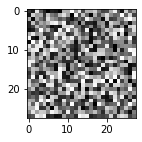

10/10 [==============================] - 0s 5ms/step


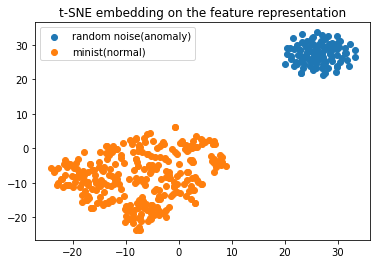

In [25]:
from sklearn.manifold import TSNE

## t-SNE embedding 

# generating anomaly image for test (radom noise image)

random_image = np.random.uniform(0,1, (100, 28,28, 1))
print("a sample from generated anomaly images(random noise image)")
plt.figure(figsize=(2, 2))
plt.imshow(random_image[0].reshape(28,28), cmap=plt.cm.gray)
plt.show()

# intermidieate output of discriminator
model = feature_extractor(D_WEIGHTS=NEW_D_WEIGHTS)
feature_map_of_random = model.predict(random_image, verbose=1)
feature_map_of_minist = model.predict(X_test[:300], verbose=1)

# t-SNE for visulization
output = np.concatenate((feature_map_of_random, feature_map_of_minist))
output = output.reshape(output.shape[0], -1)
anomaly_flag = np.array([1]*100+ [0]*300)

X_embedded = TSNE(n_components=2).fit_transform(output)
plt.title("t-SNE embedding on the feature representation")
plt.scatter(X_embedded[:100,0], X_embedded[:100,1], label='random noise(anomaly)')
plt.scatter(X_embedded[100:,0], X_embedded[100:,1], label='minist(normal)')
plt.legend()
plt.show()

----